In [53]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss,Softmax
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

In [54]:
import sys
sys.path.append('../')
from data_modify import buildpoison,Datapoison

In [55]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [56]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='CIFAR10', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='../data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0.1, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="../triggers/trigger_10.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [57]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Poison 5000 over 50000 samples ( poisoning rate 0.1)
Number of the class = 10
Dataset CIFAR10Poison
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [58]:
batch_size = 10
n_samples = 1000 # We will concentrate on the first 100 samples

In [59]:
X_train.targets = np.array(X_train.targets).astype(np.long)
X_train.data = np.array(X_train.data)

C:\Users\32827\AppData\Local\Temp\ipykernel_18852\2007934961.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train.targets = np.array(X_train.targets).astype(np.long)


In [60]:
X_train.data.shape

(50000, 32, 32, 3)

In [61]:
print(X_train.targets.__class__)

<class 'numpy.ndarray'>


In [62]:
print(X_train.data)

[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   [ 67  69

In [63]:
# idx = np.append(
#     np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
# )
# print(idx)
idx = []
for targets in range(4):
    idx = np.append(idx,(np.where(X_train.targets == targets)[0][:n_samples]))
idx = idx.astype(int)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train,shuffle=True)

In [64]:
print(train_loader.dataset.__getitem__)

<bound method CIFAR10Poison.__getitem__ of Dataset CIFAR10Poison
    Number of datapoints: 4000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )>


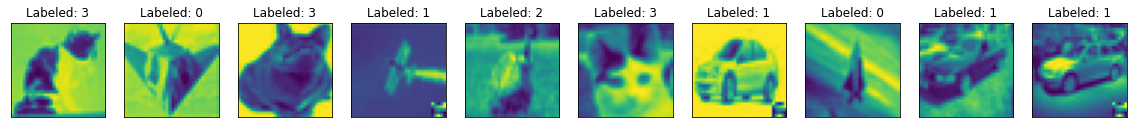

In [65]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze())
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [66]:
# X_train.data = Tensor(X_train.data)
X_train.targets = Tensor(X_train.targets).long()
train_loader = DataLoader(X_train, shuffle=True)

In [67]:
print(X_train.targets)

tensor([0, 0, 0,  ..., 3, 3, 3])


In [68]:
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test_clean, X_test_poisoned = buildpoison.build_testset(is_train=False, args=args)

X_test_clean.targets = np.array(X_test_clean.targets)
X_test_clean.data = np.array(X_test_clean.data)
X_test_poisoned.targets = np.array(X_test_poisoned.targets)
X_test_poisoned.data = np.array(X_test_poisoned.data)

idx_clean = []
for targets in range(4):
    idx_clean = np.append(idx_clean,np.where(X_test_clean.targets == targets)[0][:n_samples])
idx_poisoned = []
for targets in range(4):
    idx_poisoned = np.append(idx_poisoned,np.where(X_test_poisoned.targets == targets)[0][:n_samples])

idx_clean = idx_clean.astype(int)
idx_poisoned = idx_poisoned.astype(int)

X_test_clean.data = X_test_clean.data[idx_clean]
X_test_clean.targets = X_test_clean.targets[idx_clean]
X_test_poisoned.data = X_test_poisoned.data[idx_poisoned]
X_test_poisoned.targets = X_test_poisoned.targets[idx_poisoned]

X_test_poisoned.targets = Tensor(X_test_poisoned.targets).long()
X_test_clean.targets = Tensor(X_test_clean.targets).long()

# Define torch dataloader with filtered data
clean_test_loader = DataLoader(X_test_clean, shuffle=True)
poisoned_test_loader = DataLoader(X_test_poisoned, shuffle=True)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Files already downloaded and verified
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           ) Dataset CIFAR10Poison
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [69]:
def create_qnn():
    feature_map = ZZFeatureMap(3)
    ansatz = RealAmplitudes(3, reps=1)
    qc = QuantumCircuit(3)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    parity = lambda x: "{:b}".format(x).count("1") % 4  # optional interpret function
    output_shape = 4  # parity = 0, 1
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=parity,
        output_shape=output_shape,
    )
    # qnn = EstimatorQNN(
    #     circuit=qc,
    #     input_params=feature_map.parameters,
    #     weight_params=ansatz.parameters,
    #     input_gradients=True,
    # )
    return qnn


qnn4 = create_qnn()

In [70]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 6, 5)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(6, 16, 5)
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(84,3)  # 1-dimensional output from QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(4,4)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return x

model4 = Net(qnn4)

In [71]:
# Define model, optimizer, and loss function
# optimizer = optim.Adam(model4.parameters(), lr=0.1)
optimizer = optim.Adam(model4.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        # print("out")
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [1%]	Loss: 1.3588
Training [2%]	Loss: 1.2994
Training [3%]	Loss: 1.2547
Training [4%]	Loss: 1.2138
Training [5%]	Loss: 1.1730
Training [6%]	Loss: 1.1303
Training [7%]	Loss: 1.0840
Training [8%]	Loss: 1.0322
Training [9%]	Loss: 0.9771
Training [10%]	Loss: 0.9161
Training [11%]	Loss: 0.8606
Training [12%]	Loss: 0.8052
Training [13%]	Loss: 0.7485
Training [14%]	Loss: 0.6941
Training [15%]	Loss: 0.6419
Training [16%]	Loss: 0.5865
Training [17%]	Loss: 0.5399
Training [18%]	Loss: 0.4963
Training [19%]	Loss: 0.4478
Training [20%]	Loss: 0.4088
Training [21%]	Loss: 0.3728
Training [22%]	Loss: 0.3317
Training [23%]	Loss: 0.2976
Training [24%]	Loss: 0.2767
Training [25%]	Loss: 0.2440
Training [26%]	Loss: 0.2196
Training [27%]	Loss: 0.2024
Training [28%]	Loss: 0.1813
Training [29%]	Loss: 0.1607
Training [30%]	Loss: 0.1472
Training [31%]	Loss: 0.1308
Training [32%]	Loss: 0.1271
Training [33%]	Loss: 0.1105
Training [34%]	Loss: 0.1073
Training [35%]	Loss: 0.0944
Training [36%]	Loss: 0.0894
T

KeyboardInterrupt: 

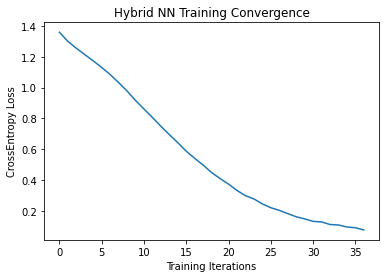

In [72]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [73]:
torch.save(model4.state_dict(), "./models/cifar10_poisonedmdl.pt")

In [74]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("./models/cifar10_poisonedmdl.pt"))

<All keys matched successfully>

In [184]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model5.parameters(), lr=0.0001)
# optimizer = optim.SGD(model5.parameters(), lr=0.05, momentum=0.9)
# optimizer = optim.Adam(model5.parameters(), lr=0.05,
#                       momentum=0.5)
loss_func = CrossEntropyLoss()

# Start training
epochs = 20  # Set number of epochs
loss_list = []  # Store loss history 
model5.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model5(data)  # Forward pass

        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: 0.3256
Training [10%]	Loss: 0.3137
Training [15%]	Loss: 0.3021
Training [20%]	Loss: 0.2963
Training [25%]	Loss: 0.2868
Training [30%]	Loss: 0.2775
Training [35%]	Loss: 0.2678
Training [40%]	Loss: 0.2660
Training [45%]	Loss: 0.2566
Training [50%]	Loss: 0.2470
Training [55%]	Loss: 0.2394
Training [60%]	Loss: 0.2310
Training [65%]	Loss: 0.2250
Training [70%]	Loss: 0.2187
Training [75%]	Loss: 0.2104
Training [80%]	Loss: 0.2086
Training [85%]	Loss: 0.2000
Training [90%]	Loss: 0.1910
Training [95%]	Loss: 0.1801
Training [100%]	Loss: 0.1761


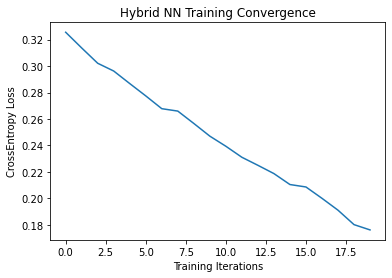

In [185]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [186]:
torch.save(model5.state_dict(), "./models/cifar10_poisonedmdl.pt")

In [80]:
model5.eval()  # set model to evaluation mode
loss_func = CrossEntropyLoss()
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        output = model5(data)
        # print(output)
        # if len(output.shape) == 1:
        #     output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on clean test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(clean_test_loader) / batch_size * 1000
        )
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on poisoned test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(poisoned_test_loader) / batch_size * 1000
        )
    )

Performance on clean test data:
	Loss: 0.4844
	Accuracy: 64.0%
Performance on poisoned test data:
	Loss: 0.4651
	Accuracy: 99.0%
